In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import os
encoding = '2345678bcdefgmnpwxy'
freq = [0]*len(encoding)

class Captcha(torch.utils.data.Dataset):
    def __init__(self, transform):
        self.img_list = []
        self.label_list = []
        self.transform = transform
        for root, dirs, files in os.walk('samples'):
            if root == 'samples':
                self.img_list.extend(files)
                for f in files:
                    label = []
                    for i in range(5):
                        label.append(encoding.index(f[i]))
                        freq[encoding.index(f[i])]+=1
                    self.label_list.append(label)
        
    def __getitem__(self, index):
        prefix = 'samples/'
        img = Image.open(prefix+self.img_list[index])
        return {
            'img': self.transform(img),
            'label': torch.Tensor(self.label_list[index]).long()
        }
    def __len__(self):
        return len(self.img_list)

In [2]:
from torchvision import transforms
transform = transforms.Compose([
                transforms.Resize((56, 224)),
                transforms.Grayscale(),
                transforms.Pad((0, 84, 0, 84)),
                transforms.ToTensor()])

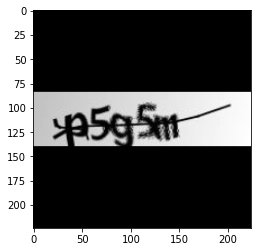

torch.Size([1, 224, 224])
Label: p5g5m
Number of data: 1070


In [3]:
import matplotlib.pyplot as plt
dataset = Captcha(transform)
plt.imshow(dataset[0]['img'].permute(1, 2, 0), cmap='gray')
plt.show()
print(dataset[0]['img'].size())
print('Label: ', end='')
for l in dataset[0]['label']:
    print(encoding[int(l.item())], end='')
print()
print("Number of data:", len(dataset))

In [4]:
import torchvision.models as models
class CaptchaSolver(nn.Module):
    def __init__(self):
        super(CaptchaSolver, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc0 = nn.Linear(1000, len(encoding))
        self.fc1 = nn.Linear(1000, len(encoding))
        self.fc2 = nn.Linear(1000, len(encoding))
        self.fc3 = nn.Linear(1000, len(encoding))
        self.fc4 = nn.Linear(1000, len(encoding))
    def forward(self, x):
        x = self.resnet(x)
        out = []
        out.append(self.fc0(x))
        out.append(self.fc1(x))
        out.append(self.fc2(x))
        out.append(self.fc3(x))
        out.append(self.fc4(x))
        return out
captchaSolver = CaptchaSolver().cuda()

In [5]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(captchaSolver.parameters())

max_epochs = 15
log_interval = 1

In [6]:
avg_acc_list = []
avg_loss_list = []

print("Start training...")
for epoch in range(1, max_epochs+1):
    loss_list = []
    total_count = 0
    acc_count = 0
    captchaSolver.train()
    for data in train_loader:
        optimizer.zero_grad()
        img = data['img'].cuda()
        label = data['label'].cuda()
        out = captchaSolver(img)
        loss = None
        for i in range(5):
            if loss is None:
                loss = criterion(out[i], label[:, i])
            else:
                loss += criterion(out[i], label[:, i])
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        pred_label = None
        for i in range(5):
            _, pred = torch.max(out[i], 1)
            if pred_label is None:
                pred_label = pred.view(-1, 1)
            else:
                pred_label = torch.cat((pred_label, pred.view(-1, 1)), 1)
        assert label.shape[0]==((pred_label == label).all(1).shape[0])
        total_count += label.shape[0]
        acc_count += (pred_label == label).all(1).sum().item()
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    avg_acc_list.append(acc)
    avg_loss_list.append(loss)
    torch.save(captchaSolver.state_dict(), 'captcha_solver_params.pth')
        
    if epoch % log_interval == 0:
        print('')
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(acc, loss))

Start training...

==================== Epoch 1 ====================
Train Acc: 0.000000 Train Loss: 15.355128

==================== Epoch 2 ====================
Train Acc: 0.000000 Train Loss: 12.834360

==================== Epoch 3 ====================
Train Acc: 0.001869 Train Loss: 10.501959

==================== Epoch 4 ====================
Train Acc: 0.017757 Train Loss: 8.178619

==================== Epoch 5 ====================
Train Acc: 0.040187 Train Loss: 6.385097

==================== Epoch 6 ====================
Train Acc: 0.114019 Train Loss: 4.899774

==================== Epoch 7 ====================
Train Acc: 0.247664 Train Loss: 3.576752

==================== Epoch 8 ====================
Train Acc: 0.421495 Train Loss: 2.511960

==================== Epoch 9 ====================
Train Acc: 0.520561 Train Loss: 1.884671

==================== Epoch 10 ====================
Train Acc: 0.597196 Train Loss: 1.401313

==================== Epoch 11 ====================
Train 